In [4]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import datetime                         # for datetime operations

In [5]:
data_path = 'data/pulStr_16-07-2023/' # path to data files
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current date and time

In [33]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

Data loaded successfully with N = 75 flies and 150 maximum trials


In [34]:
# QUALITY CONTROL

if quality_control == 'minimal':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
if quality_control == 'full':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

34/75 (45.33) flies passed quality control


DoubleT_Learning


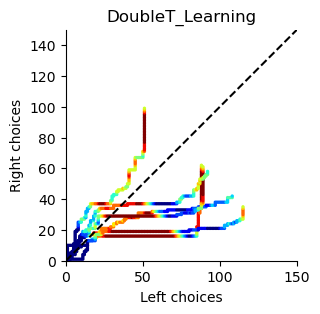

HalfT_Learning


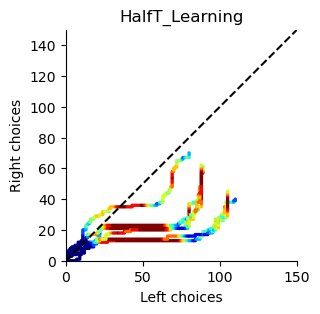

HighI_Learning


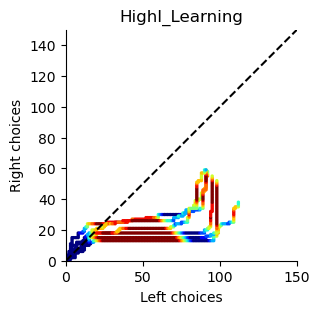

LowI_Learning


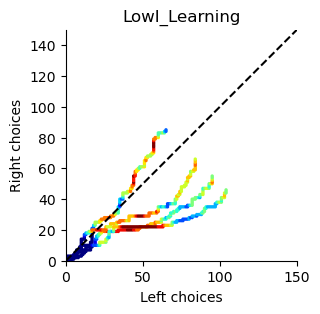

SplitT_Learning


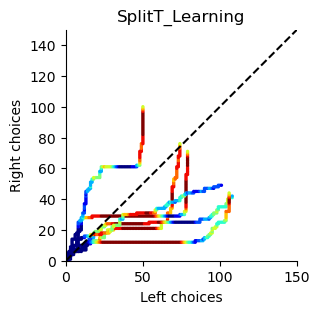

Standard_Learning


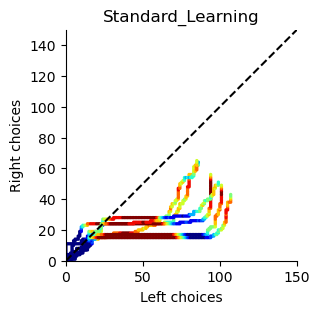

In [47]:
current_exp = ""
for exp in metadata['Fly Experiment'].sort_values().unique():
    if exp[:-4].split('_reciprocal')[0] != current_exp:
        try:
            ax.plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
            ax.set_xlabel('Left choices')
            ax.set_ylabel('Right choices')
            ax.set_xlim([0, choice_set.shape[1]])
            ax.set_ylim([0, choice_set.shape[1]])
            ax.set_title(current_exp)
            ax.set_aspect('equal')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.show()
        except:
            pass
        print(exp[:-4].split('_reciprocal')[0])
        current_exp = exp[:-4].split('_reciprocal')[0]
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    choice_set = choice_data[metadata[metadata['Fly Experiment'] == exp].index]
    reward_set = reward_data[metadata[metadata['Fly Experiment'] == exp].index]
    N_set = choice_set.shape[0]
    for i in range(N_set):
        reward_rate = np.convolve(reward_set[i,:], np.ones(10)/10, mode='same')
        if "_reciprocal" in exp:
            ax.scatter(np.cumsum(choice_set[i,:]==1), np.cumsum(choice_set[i,:]==0), c=reward_rate, cmap='jet', s=2)
        else:
            ax.scatter(np.cumsum(choice_set[i,:]==0), np.cumsum(choice_set[i,:]==1), c=reward_rate, cmap='jet', s=2)

ax.plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
ax.set_xlabel('Left choices')
ax.set_ylabel('Right choices')
ax.set_xlim([0, choice_set.shape[1]])
ax.set_ylim([0, choice_set.shape[1]])
ax.set_title(current_exp)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [84]:
# fit multifactor ql model with softmax choice rule and fixed learning rate

def fit_ql(params,c,r,e,return_probs=False):
    liks = []
    alpha, beta, rs = params[0], params[1], params[2:]
    if return_probs: ps = []
    for i in range(len(c)):
        # remove nan values
        ct = c[i][~np.isnan(c[i])].copy()
        rt = r[i][~np.isnan(r[i])].copy()
        q = np.zeros(2)
        if return_probs: p = []
        for j in range(len(ct)):
            pval = np.clip(np.exp(beta*q[1])/np.sum(beta*np.exp(q)),1e-6,1-1e-6)
            if return_probs: p.append(pval)
            liks.append(np.log(pval)*ct[j] + np.log(1-pval)*(1-ct[j]))
            q[ct[j]] = q[ct[j]] + alpha*(rt[j]*rs[e[i]]-q[ct[j]])
    return -np.sum(liks) if not return_probs else (-np.sum(liks), np.array(p))

r = reward_data.copy()
c = choice_data.copy()
exp_mapper = {exp:i for i, exp in enumerate(metadata['Fly Experiment'].apply(lambda x: x.split('.')[0].split('_reciprocal')[0]).unique())}
e = metadata['Fly Experiment'].apply(lambda x: exp_mapper[x.split('.')[0].split('_reciprocal')[0]]).values
max_e = np.max(e)
init_params = np.array([0.5,0.5]+[0.5]*(max_e+1))
bounds = [(0,1),(1e-6,1-1e-6)]+[(0,5)]*(max_e+1)

res = opt.dual_annealing(fit_ql, bounds, args=(c,r,e), maxiter=1000, seed=1234, x0=init_params, no_local_search=True)

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_21726/3546330171.py:28: DeprecationWarning: dual_annealing argument 'local_search_options' is deprecated in favor of 'minimizer_kwargs' and will be removed in SciPy 1.10.0.
  res = opt.dual_annealing(fit_ql, bounds, args=(c,r,e), maxiter=1000, seed=1234, x0=init_params, no_local_search=True, local_search_options={'method':'Nelder-Mead'})


KeyboardInterrupt: 

In [83]:
res.x

array([1.      , 0.999999, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      ])